# Demo on handling spiking data

In this demo, we illustrate how to use spiking data to compute RDMs. For this illustration, we use the data by [Cadena et al. (2019)](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1006897) . Before running this demo you need to download this data from here: [https://doi.org/10.12751/g-node.2e31e3](https://doi.org/10.12751/g-node.2e31e3) . Simply download as a zip and unpack. Inside you will find a file called `data_binned_responses/cadena_ploscb_data.pkl`. Copy this file into the same folder as this demo notebook.

Additionally you will need the following packages installed and we will import them now:

In [1]:
# imports
import pickle as pkl
import numpy as np
import rsatoolbox
import matplotlib.pyplot as plt

Now we can load the data using pickle as follows:

In [2]:
# loading the data
with open('cadena_ploscb_data.pkl', 'rb') as f:
    data_raw = pkl.load(f)

The content of this file is a dictionary with different information about recording data collected from macaque V1 recordings in response of a total of 27 neurons to 7250 different stimuli. The following comand lists the fields and their shapes:

In [3]:
[(i,data_raw[i].shape) for i in data_raw]

[('repetitions', (166,)),
 ('subject_id', (166,)),
 ('session_id', (166,)),
 ('image_ids', (7250, 1)),
 ('unit_id', (166,)),
 ('image_types', (7250, 1)),
 ('images', (7250, 140, 140)),
 ('responses', (4, 7250, 166)),
 ('image_numbers', (7250, 1))]

The fields have the following content:
- `repetitions`: how many repeats were shown in the session
- `subject_id`: which of two monkeys was recorded from (4 or 34)
- `session_id`: which of 17 recording sessions the data comes from
- `image_ids`: just a running index of the images
- `unit_id`: which of 27 units was recorded 
- `image_types`: image type of each image (original or one of 4 layers used for texture generation)
- `images`: The actual images shown
- `responses`: the spike counts per image, session and neuron for up to 4 repetitions
- `image_numbers`, image index of the original image

## Generating a Dataset object
To use the data in rsatoolbox we need to rearrange it into a recordings x channels format. The simplest version of generating a Dataset object here follows the given data structure. We simply turn the (up to) 4 repetitions into actual repeated rows:

In [4]:
# reshaping
responses = np.reshape(data_raw['responses'], (4*7250, 166))
image_ids = np.repeat(data_raw['image_ids'], 4, 1).T.flatten()
image_types = np.repeat(data_raw['image_types'], 4, 1).T.flatten()
image_numbers = np.repeat(data_raw['image_numbers'], 4, 1).T.flatten()
repetition = np.repeat([np.arange(4)], 7250, 0).T.flatten()

In [5]:
# removing NaN rows
idx_ok = ~np.any(np.isnan(responses), 1)
responses = responses[idx_ok]
image_ids = image_ids[idx_ok]
image_types = [str(i) for i in image_types[idx_ok]]
image_numbers = image_numbers[idx_ok]
repetition = repetition[idx_ok]

Here, we removed all images and repetitions that are missing in any neurons. There were apparently 4 sessions with one of the monkeys during which only a subset of images were shown. For now we simply focus on the images that were not excluded. There is a comment on missing values in the end of this tutorial.

Now can create a Dataset object with the data and all the descriptive data we have, by simply telling the rsatoolbox which descriptors go with which dimension:

In [6]:
# creating the Dataset object:
data = rsatoolbox.data.Dataset(
    responses,
    descriptors=None,
    obs_descriptors={
        'image_ids': image_ids,
        'image_types': image_types,
        'image_numbers': image_numbers,
        'repetition': repetition
    },
    channel_descriptors={
        'subject_id': data_raw['subject_id'],
        'session_id': data_raw['session_id'],
        'unit_id': data_raw['unit_id'],
    },
)

## Calculating RDMs
As is frequently the case for recording data, some neurons appear only in some sessions, which leaves us with some flexibility in how to pool the data for constructing RDMs. We will go through a few different options here.

We can calculate an RDM now with a single call to `calc_rdm`. By default this calculates a squared euclidean distance matrix. As we are dealing with spiking neuron data the symmetrized KL-divergence between poission distributions seems more adequate. We select this distance measure by passing the `method=poisson` argument:

In [7]:
rdm_overall = rsatoolbox.rdm.calc_rdm(data, method='poisson', descriptor='image_ids')

We can also split our dataset into subsets and compute RDMs for each of them. For example, this is how to calculate a RDM for each session or for each image type:

In [8]:
rdm_sessions = rsatoolbox.rdm.calc_rdm(data.split_channel('session_id'), method='poisson', descriptor='image_ids')

In [9]:
# here we switch to image_numbers as the descriptor, such that the RDMs are in the same reference frame.
rdm_type = rsatoolbox.rdm.calc_rdm(data.split_obs('image_types'), method='poisson', descriptor='image_numbers')

You can get the raw RDM data with the following command:

In [10]:
rdm_mat = rdm_sessions.get_matrices()

This is a simple command to have a look at individual RDMs. We here show only the first 200 images agains each other, because the whole matrix is very large, which makes it hard to see anything across the whole matrix:

(<matplotlib.image.AxesImage at 0x7f81110428f0>,
 <matplotlib.colorbar.Colorbar at 0x7f8110fa6c50>)

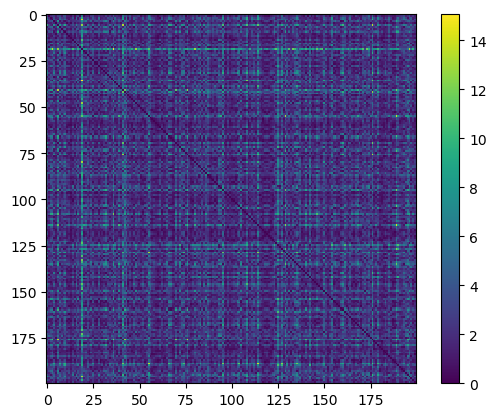

In [29]:
plt.imshow(rdm_mat[5,0:200,0:200], interpolation='none'), plt.colorbar()

Analogously for the RDMs per type, where some of the entries are missing, because some of the image versions were not among the images shown in all sessions:

In [12]:
rdm_mat_type = rdm_type.get_matrices()

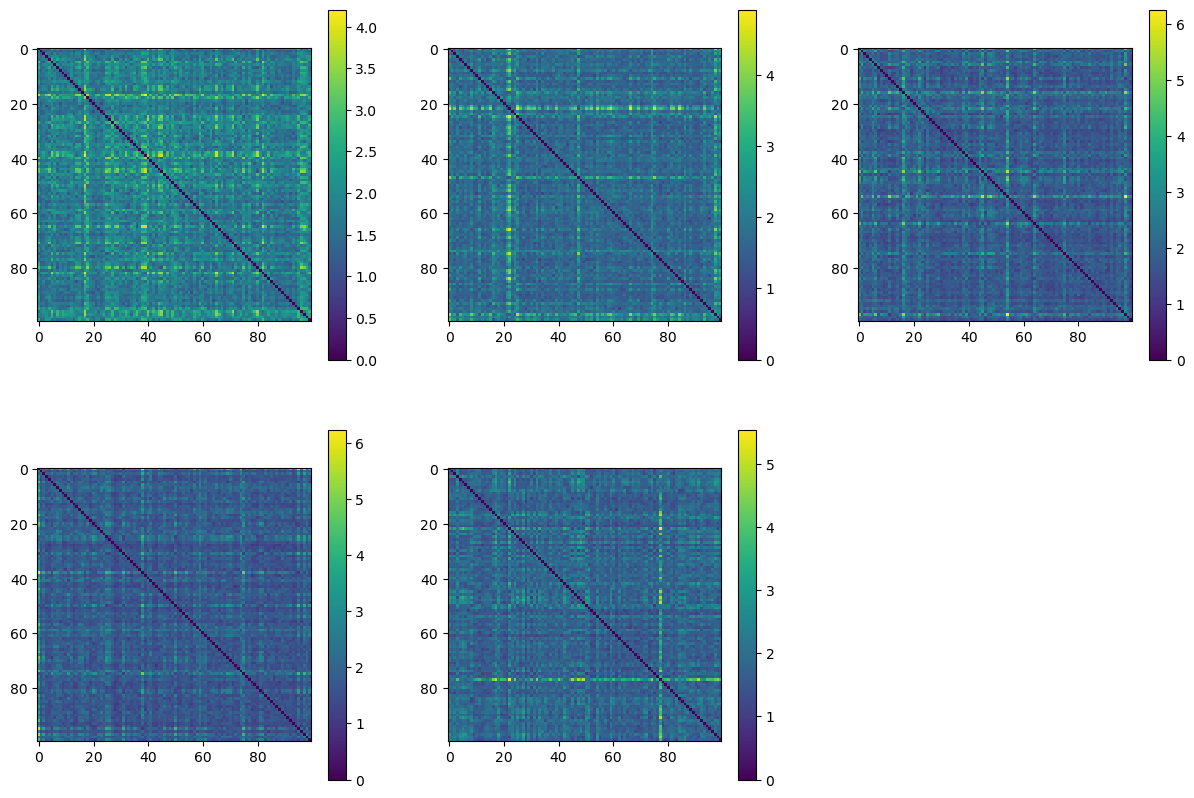

In [13]:
plt.figure(figsize=(15,10))
for i in range(5):
    plt.subplot(2,3,i+1)
    plt.imshow(rdm_mat_type[i,0:100,0:100], interpolation='none')
    plt.colorbar()

## Different Dissimilarity measures

Besides the symmetrized KL between poissons we used so far there are some other dissimilarity measures that have been used previously.

The first is to use a variance stabilizing transform first and then compute a simple Euclidean distance.
To achieve this, first apply the transform to the data and then compute a RDM:

In [14]:
data_sqrt = rsatoolbox.data.Dataset(
    np.sqrt(responses),
    descriptors=None,
    obs_descriptors={
        'image_ids': image_ids,
        'image_types': image_types,
        'image_numbers': image_numbers,
        'repetition': repetition
    },
    channel_descriptors={
        'subject_id': data_raw['subject_id'],
        'session_id': data_raw['session_id'],
        'unit_id': data_raw['unit_id'],
    },
)

In [15]:
rdm_sqrt = rsatoolbox.rdm.calc_rdm(data_sqrt, method='euclidean', descriptor='image_ids')

### Crossvalidated dissimilarities
The dissimilarity measures we calculated so far are biased estimates, due to the noise in the response patterns. To avoid this problem one can use crossvalidated dissimilarity measures. These measures combine dissimilarities from different repetitions into an unbiased estimate of the noise free dissimilarity. If the noise in separate repetitions is uncorrelated, these estimates are unbiased.

Any unbiased estimate for the dissimilarity necessarily yields negative dissimilarity estimates sometimes to cancel positive deviations from small true dissimilarities. This is not problematic for comparisons between RDMs and model evaluations. If you need a RDM that represents a proper distance for some reason this can be problematic though.

There are two variants of crossvalidated distances that are relevant for spiking data: The crossnobis, which is the crossvalidated equivalent of the Euclidean and Mahalanobis distances. And the crossvalidated symmetrized KL-divergence between Poisson distributions. The choice between the two follows the same logic as for the non-crossvalidated versions.

In the rsatoolbox, computing these RDMs can be done with the same function as for the non-crossvalidated ones. It just requires one more input: A variable that has a different value for each of the repetitions that are assumed to be independent. Here, this is obviously the `'repetition'`.

In [16]:
rdm_crossnobis = rsatoolbox.rdm.calc_rdm(
    data_sqrt,
    method='crossnobis',
    descriptor='image_ids',
    cv_descriptor='repetition')

/Users/heiko/rsatoolbox/src/rsatoolbox/data/computations.py:36: RuntimeWarning: invalid value encountered in multiply
  average = np.nan * np.empty(


In [17]:
rdm_poisson_cv = rsatoolbox.rdm.calc_rdm(
    data,
    method='poisson_cv',
    descriptor='image_ids',
    cv_descriptor='repetition')

In [18]:
rdm_mat_cross = rdm_poisson_cv.get_matrices()

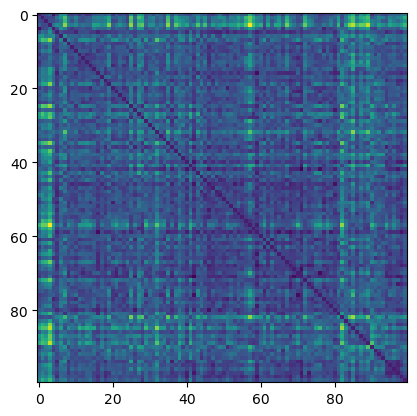

In [19]:
plt.imshow(rdm_mat_cross[0, 0:100, 0:100])

## A comment on missing values
All computations up to this point assumed that the data are complete and balanced, i.e. that all neurons were measured for all stimuli equally often. Due to technical constraints, this is often not the case for electrophysiological recordings.

Even in this example dataset 1000 images were not shown in some of the sessions and the 3rd and 4th repetitions were only performed in some of the sessions.

What corrections are necessary primarily depends on which parts of the data are missing:
- The simplest case are missing stimulus presentations, which is still hadled by `calc_rdm`. The estimates of the different distances will be differently accurate, but we the individual stimulus presentations are simply averaged for the RDM calculation and calc_rdm handles this case just fine. 
- If we want to use measurements that are missing some measurement channels, we need a different function `calc_rdm_unbalanced`, because each comparison between two images may now be based on a different subset of neurons. Thus, we need to go through all combinations of rows to use the maximum number of datapoints for each comparison. The function `calc_rdm_unbalanced` is substantially slower than calc_rdm to allow going through all these combinations.

For illustration the following code snippets load the data again and this time do not remove rows with missing neurons.

In [20]:
# reshaping
responses = np.reshape(data_raw['responses'], (4*7250, 166))
image_ids = np.repeat(data_raw['image_ids'], 4, 1).T.flatten()
image_types = np.repeat(data_raw['image_types'], 4, 1).T.flatten()
image_numbers = np.repeat(data_raw['image_numbers'], 4, 1).T.flatten()
repetition = np.repeat([np.arange(4)], 7250, 0).T.flatten()

In [21]:
# removing only rows that contain only NaNs
idx_ok = ~np.all(np.isnan(responses), 1)
responses = responses[idx_ok]
image_ids = image_ids[idx_ok]
image_types = [str(i) for i in image_types[idx_ok]]
image_numbers = image_numbers[idx_ok]
repetition = repetition[idx_ok]

In [22]:
# creating the Dataset object:
data_unbalanced = rsatoolbox.data.Dataset(
    responses,
    descriptors=None,
    obs_descriptors={
        'image_ids': image_ids,
        'image_types': image_types,
        'image_numbers': image_numbers,
        'repetition': repetition
    },
    channel_descriptors={
        'subject_id': data_raw['subject_id'],
        'session_id': data_raw['session_id'],
        'unit_id': data_raw['unit_id'],
    },
)

Now we can use calc_rdm_unbalanced to compute the RDMs using all data. To avoid a long wait time we here first subset the first 200 images from the dataset and only calculate the RDM for these values. If you have time to wait you can replace the line with `dat = data_unbalanced` to compute the whole big RDM.

In [23]:
dat = data_unbalanced.subset_obs('image_ids', np.arange(201))

In [24]:
rdm_unbalanced = rsatoolbox.rdm.calc_rdm_unbalanced(dat, method='poisson', descriptor='image_ids')

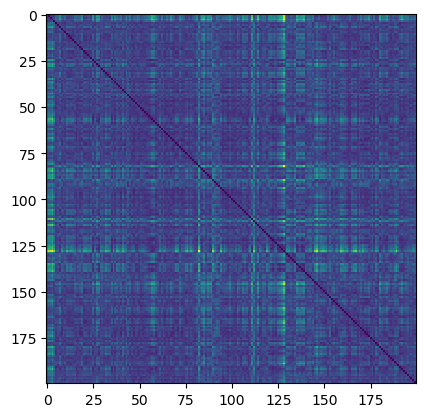

In [25]:
# plotting the RDM again for illustration:
plt.imshow(rdm_unbalanced.get_matrices()[0][:200,:200], interpolation='none')

The function takes the same additional inputs as `calc_rdm`, i.e. you can use it compute the other dissimilarity measures as well.

Note, that this calculation yields the same results as `calc_rdm` if the dataset is in fact balanced and we are using one of the Euclidean distance based dissimilarities. Thus, `calc_rdm` is preferred if the data can be handled by this function. 

For the symmetrized KL between poisson distributions this is not exactly true, but the RDMs are still extremely similar. To illustrate this fact, the following code computes the RDM from only the balanced part of the data using `calc_rdm_unbalanced`.

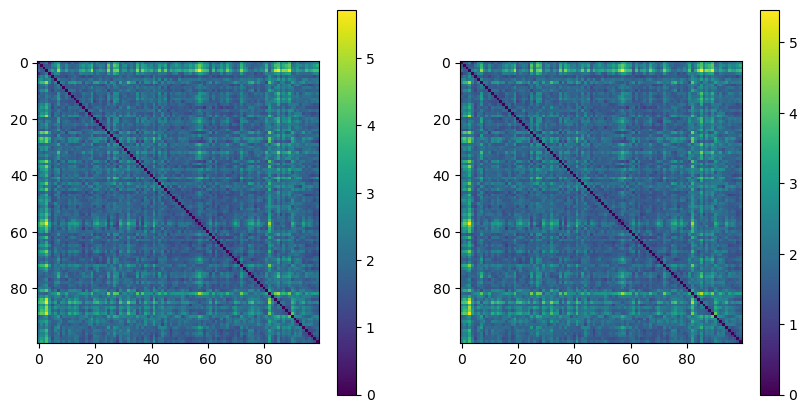

In [30]:
rdm_small_ub = rsatoolbox.rdm.calc_rdm_unbalanced(
    data.subset_obs('image_ids', np.arange(201)),
    method='poisson',
    descriptor='image_ids')
rdm_small = rsatoolbox.rdm.calc_rdm(
    data.subset_obs('image_ids', np.arange(201)),
    method='poisson',
    descriptor='image_ids')
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(rdm_small_ub.get_matrices()[0][:100,:100], interpolation='none')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(rdm_small.get_matrices()[0][:100,:100], interpolation='none')
plt.colorbar()

In [32]:
# the similarity between the two is very high indeed, with a correlation above 0.999
rsatoolbox.rdm.compare(rdm_small_ub, rdm_small)

array([[0.99935716]])

### Conclusion
In this demo, you saw how to compute RDMs from spiking data. Based on these RDMs, comparisons continue exactly as for RDMs from other data. See `demo_bootstrap` for example.